# Section 4a: Hardware Utilization Analysis

In [1]:
import pyspark.sql.functions as F
from util.read_and_print_df import *
from util.handle_nan import *
from util.extract_json_attributes import *
from util.plotting import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import pandas as pd

In [4]:
spark = get_spark_session()

Assigning 541 GB of memory per spark driver and executor, and use 126 cores.


In [5]:
df_node_hardware_info = spark.read.parquet(path_node_hardware_info)
df_node_hardware_info.show(5, False)

+------+---------+-------------------------+--------------------+------------------+--------------+---------------------+---------+--------------------+----------------------+-------------+--------------------------------+---------+-------------------------+----------------+------------+---------+----------------------+-------------+
|node  |cpu_model|cpu_core_count_per_socket|cpu_threads_per_core|cpu_tdp_per_socket|cpu_t_case_max|cpu_per_core_temp_max|cpu_count|cpu_core_count_total|cpu_memory_bytes_total|cpu_tdp_total|node_filesystem_size_bytes_total|gpu_model|gpu_memory_bytes_per_card|gpu_tdp_per_card|gpu_temp_max|gpu_count|gpu_memory_bytes_total|gpu_tdp_total|
+------+---------+-------------------------+--------------------+------------------+--------------+---------------------+---------+--------------------+----------------------+-------------+--------------------------------+---------+-------------------------+----------------+------------+---------+----------------------+-------

In [15]:
df_prom = spark.read.parquet(path_node_dataset)

df_prom_node_data_2 = df_prom.join(df_node_hardware_info, how='left', on="node")
df_prom_node_data_2.show(5, False)

+-----+---------+-------------------+-----------------+-----------+----------------+---+------------------------+-----------------------+---------------------------+----------+----------+------------------------+----------------------------+-------------------------+-----------------------+-----------------+------------------------+----------------------------+---------------+-----------------------+------------------------+----------------------+-----------------------------+--------------------------+------------------+-------------------------+-------------------------+------------------+----------------+---------------------------+----------------------------+---------------------------+-------------------------------+-------------------------+-------------------------------------+--------------------------------+---------------------------------+------------------------------+--------------------------+---------------------------+--------------------------+------------------------

We calculate memory usage ratio as `node_memory_Active_bytes / node_memory_MemTotal_bytes`
(https://www.tigera.io/learn/guides/prometheus-monitoring/prometheus-metrics/)
`node_memory_Active_bytes` is present as metric in the dataset, but `node_memory_MemTotal_bytes` is not. We used the `cpu_memory_bytes_total` from the node hardware info dataset as substitute for `node_memory_MemTotal_bytes`.

In [7]:
df_prom_node_data_3 = df_prom_node_data_2.withColumn('node_load_1_ratio', F.col('node_load1') / F.col('cpu_core_count_total'))
df_prom_node_data_3 = df_prom_node_data_3.withColumn('cpu_power_sum_ratio', F.col('node_rapl_package_power_sum') / F.col('cpu_tdp_total'))
df_prom_node_data_3 = df_prom_node_data_3.withColumn('cpu_mem_ratio', F.col('node_memory_Active_bytes') / F.col('cpu_memory_bytes_total'))
# normalize by taking ambient temp as min value
# cpu package temp ratios
df_prom_node_data_3 = df_prom_node_data_3.withColumn('cpu_temp_mean_ratio', (F.col('node_thermal_zone_temp_mean') - F.col('node_ambient_temp')) / (F.col('cpu_t_case_max') - F.col('node_ambient_temp')))
df_prom_node_data_3 = df_prom_node_data_3.withColumn('cpu_temp_min_ratio', (F.col('node_thermal_zone_temp_min') - F.col('node_ambient_temp')) / (F.col('cpu_t_case_max') - F.col('node_ambient_temp')))
df_prom_node_data_3 = df_prom_node_data_3.withColumn('cpu_temp_max_ratio', (F.col('node_thermal_zone_temp_max') - F.col('node_ambient_temp')) / (F.col('cpu_t_case_max') - F.col('node_ambient_temp')))
# cpu core temp ratios
df_prom_node_data_3 = df_prom_node_data_3.withColumn('cpu_core_temp_min_ratio', (F.col('node_hwmon_temp_celsius_min') - F.col('node_ambient_temp')) / (F.col('cpu_per_core_temp_max') - F.col('node_ambient_temp')))
df_prom_node_data_3 = df_prom_node_data_3.withColumn('cpu_core_temp_max_ratio', (F.col('node_hwmon_temp_celsius_max') - F.col('node_ambient_temp')) / (F.col('cpu_per_core_temp_max') - F.col('node_ambient_temp')))
df_prom_node_data_3 = df_prom_node_data_3.withColumn('cpu_core_temp_mean_ratio', (F.col('node_hwmon_temp_celsius_mean') - F.col('node_ambient_temp')) / (F.col('cpu_per_core_temp_max') - F.col('node_ambient_temp')))
# gpu ratios
df_prom_node_data_3 = df_prom_node_data_3.withColumn('gpu_power_sum_ratio', F.col('nvidia_gpu_power_usage_milliwatts_sum') / 1000 / F.col('gpu_tdp_total'))
df_prom_node_data_3 = df_prom_node_data_3.withColumn('gpu_mem_sum_ratio', F.col('nvidia_gpu_memory_used_bytes_sum') / F.col('gpu_memory_bytes_total'))
df_prom_node_data_3 = df_prom_node_data_3.withColumn('gpu_temp_mean_ratio', (F.col('nvidia_gpu_temperature_celsius_mean') - F.col('node_ambient_temp')) / (F.col('gpu_temp_max') - F.col('node_ambient_temp')))
df_prom_node_data_3 = df_prom_node_data_3.withColumn('gpu_temp_min_ratio', (F.col('nvidia_gpu_temperature_celsius_min') - F.col('node_ambient_temp')) / (F.col('gpu_temp_max') - F.col('node_ambient_temp')))
df_prom_node_data_3 = df_prom_node_data_3.withColumn('gpu_temp_max_ratio', (F.col('nvidia_gpu_temperature_celsius_max') - F.col('node_ambient_temp')) / (F.col('gpu_temp_max') - F.col('node_ambient_temp')))

In [8]:
# clip all ratios to min 0 (due to numerical inaccuracies in the collected data)
for c in df_prom_node_data_3.columns:
    if 'ratio' in c:
        df_prom_node_data_3 = df_prom_node_data_3.withColumn(c, when(F.col(c) < 0, 0).otherwise(F.col(c)))

# change all cpu-only node gpu column values to 0.0
for c in df_prom_node_data_3.columns:
    if 'gpu' in c and 'ratio' in c:
        df_prom_node_data_3 = df_prom_node_data_3.withColumn(c, when(F.col('gpu_node') == 0, 0.0).otherwise(F.col(c)))

# clip node_load_1_ratio to max 1.0, as a cpu with at least as many threads as cores is already at 100% load
df_prom_node_data_3 = df_prom_node_data_3.withColumn('node_load_1_ratio', when(F.col('node_load_1_ratio') > 1, 1).otherwise(F.col('node_load_1_ratio')))

In [9]:
# 10 min runtime
# all newly generated columns
cols = ['node_load_1_ratio', 'cpu_power_sum_ratio', 'cpu_mem_ratio', 'cpu_temp_max_ratio', 'cpu_core_temp_max_ratio', 'gpu_power_sum_ratio', 'gpu_mem_sum_ratio', 'gpu_temp_max_ratio']
cols_dict = {
    'node_load_1_ratio': 'Node Load 1 [\%]',
    'cpu_power_sum_ratio': 'CPU Power [\%]',
    'cpu_mem_ratio': 'CPU Memory [\%]',
    'cpu_temp_max_ratio': 'CPU Package Temp. [\%]',
    'cpu_core_temp_max_ratio': 'CPU Core Temp. [\%]',
    'gpu_power_sum_ratio': 'GPU Power [\%]',
    'gpu_mem_sum_ratio': 'GPU Memory [\%]',
    'gpu_temp_max_ratio': 'GPU Temp. [\%]'
}

df_double_regular = df_prom_node_data_3.filter(F.col('gpu_node') == 0).select(cols).toPandas()
df_double_ml = df_prom_node_data_3.filter(F.col('gpu_node') == 1).select(cols).toPandas()

df_double_regular = df_double_regular * 100
df_double_ml = df_double_ml * 100

# clip to 99.99th percentile to remove outliers
for c in cols:
    df_double_regular[c] = df_double_regular[c].clip(upper=df_double_regular[c].quantile(0.9999))
    df_double_ml[c] = df_double_ml[c].clip(upper=df_double_ml[c].quantile(0.9999))

# add gpu_node col back
df_double_regular_2 = df_double_regular.copy()
df_double_regular_2['gpu_node'] = 0
df_double_ml_2 = df_double_ml.copy()
df_double_ml_2['gpu_node'] = 1
df_double = pd.concat([df_double_regular_2, df_double_ml_2], axis=0).round(0) # round for easier plotting, so multiple outliers stack on top of each other

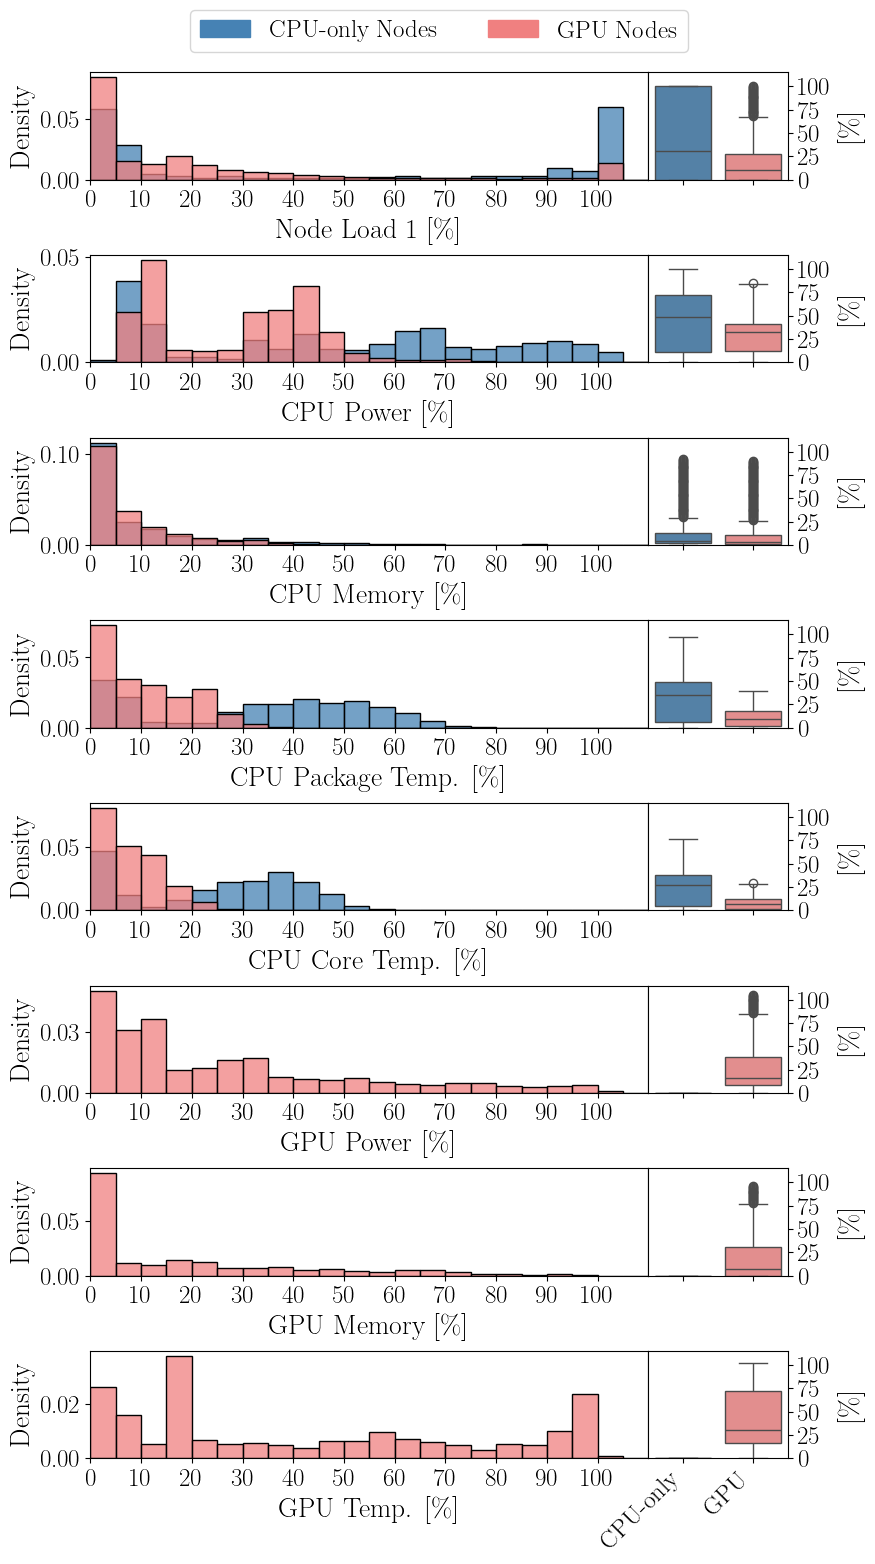

In [10]:
# 10-30 min runtime (varies greatly with sns version, tested with 0.12.2 (10 min) and 0.13.2 (30 min))
set_one_column_figure_font( height_multiplier= 3)

ncols = 2
nrows = int(len(cols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, gridspec_kw={'width_ratios': [4, 1]})
fig.subplots_adjust(hspace=0.7)
fig.subplots_adjust(wspace=0.0)

for i, c in enumerate(cols):
    ax = axes[i, 0]
    df = df_double[[c, 'gpu_node']]
    if 'gpu' not in c:
        sns.histplot(df_double_regular[c].round(0), kde=False, label=f'Non-GPU', color=non_gpu_color, ax=ax, line_kws={'linewidth': 2}, bins=range(0, 111, 5), stat="density")
    sns.histplot(df_double_ml[c].round(0), kde=False, label=f'GPU', color=gpu_color, ax=ax, line_kws={'linewidth': 2}, bins=range(0, 111, 5), stat="density")
    
    ax.set_ylabel('Density')
    ax.set_xlabel(cols_dict[c])
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xlim(0, 110)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.legend().remove()

    ax2 = axes[i, 1]
    # put ax2 yaxis on the right side of the subplot
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")

    bp = sns.boxplot(data=df, x='gpu_node', y=c, hue='gpu_node', ax=ax2, palette=[non_gpu_color, gpu_color], order=[0, 1], showfliers=True,  hue_order=[0, 1], dodge=False)


    # remove all duplicated outlier dots to reduce pdf size
    # millions of overlapping outliers are not visible anyway
    for l in bp.lines:
        if len(l.get_ydata()) > 2:
            new_ydata = np.unique(l.get_ydata())
            l.set_ydata(new_ydata)
            l.set_xdata(l.get_xdata()[:len(new_ydata)])

    ax2.set_ylabel('[\%]')
    ax2.set_xlabel('')
    ax2.xaxis.set_ticks([0, 1])
    if i == (len(cols) - 1):
        ax2.set_xticklabels(['CPU-only', 'GPU'])
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    else:
        ax2.set_xticklabels([])
    ax2.set_yticks(np.arange(0, 101, 25))
    ax2.set_ylim(0, 115)
    ax2.legend().remove()

plt.legend(handles=[mpatches.Patch(color=non_gpu_color, label='CPU-only Nodes'), mpatches.Patch(color=gpu_color, label='GPU Nodes')], loc='upper center', bbox_to_anchor=(-1.5, 13.6), ncol=2)
plt.tight_layout()
plt.show()
fig.savefig('plots/section_4/utilization_regular_vs_ml_distributions_density_box.png', dpi=900, bbox_inches='tight')
fig.savefig('plots/section_4/utilization_regular_vs_ml_distributions_density_box.pdf', bbox_inches='tight')

In [11]:
df_double.describe()

,node_load_1_ratio,cpu_power_sum_ratio,cpu_mem_ratio,cpu_temp_max_ratio,cpu_core_temp_max_ratio,gpu_power_sum_ratio,gpu_mem_sum_ratio,gpu_temp_max_ratio,gpu_node
count,1.278277e+08,1.278277e+08,1.278277e+08,1.278277e+08,1.278277e+08,1.278277e+08,1.278277e+08,1.278277e+08,1.278277e+08
mean,4.493632e+01,4.595084e+01,1.008437e+01,3.002018e+01,2.305366e+01,2.629734e+00,1.832744e+00,4.146844e+00,9.822657e-02
std,4.443622e+01,3.031956e+01,1.436649e+01,2.111640e+01,1.600227e+01,1.135784e+01,9.259290e+00,1.646279e+01,2.976207e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.200000e+01,1.000000e+00,6.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.100000e+01,4.400000e+01,4.000000e+00,3.300000e+01,2.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+02,6.900000e+01,1.300000e+01,4.800000e+01,3.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+02,1.000000e+02,9.200000e+01,9.700000e+01,7.600000e+01,1.050000e+02,9.600000e+01,1.020000e+02,1.000000e+00


In [12]:
df_double_regular.describe()

,node_load_1_ratio,cpu_power_sum_ratio,cpu_mem_ratio,cpu_temp_max_ratio,cpu_core_temp_max_ratio,gpu_power_sum_ratio,gpu_mem_sum_ratio,gpu_temp_max_ratio
count,1.152716e+08,1.152716e+08,1.152716e+08,1.152716e+08,1.152716e+08,115271641.0,115271641.0,115271641.0
mean,4.756557e+01,4.783780e+01,1.031743e+01,3.214011e+01,2.474143e+01,0.0,0.0,0.0
std,4.499856e+01,3.089782e+01,1.460478e+01,2.098012e+01,1.585960e+01,0.0,0.0,0.0
min,0.000000e+00,0.000000e+00,5.298489e-03,0.000000e+00,0.000000e+00,0.0,0.0,0.0
25%,5.000000e-01,1.143680e+01,1.516998e+00,6.349206e+00,5.194805e+00,0.0,0.0,0.0
50%,3.137500e+01,4.911255e+01,3.597796e+00,3.548387e+01,2.727273e+01,0.0,0.0,0.0
75%,1.000000e+02,7.165413e+01,1.310875e+01,4.920635e+01,3.815789e+01,0.0,0.0,0.0
max,1.000000e+02,9.981036e+01,9.174352e+01,9.666667e+01,7.631579e+01,0.0,0.0,0.0


In [13]:
df_double_ml.describe()

,node_load_1_ratio,cpu_power_sum_ratio,cpu_mem_ratio,cpu_temp_max_ratio,cpu_core_temp_max_ratio,gpu_power_sum_ratio,gpu_mem_sum_ratio,gpu_temp_max_ratio
count,1.255608e+07,1.255608e+07,1.255608e+07,1.255608e+07,1.255608e+07,1.255608e+07,1.255608e+07,1.255608e+07
mean,2.110471e+01,2.857754e+01,8.061655e+00,1.021246e+01,7.358645e+00,2.681078e+01,1.866584e+01,4.217956e+01
std,2.918326e+01,1.586820e+01,1.160606e+01,8.578851e+00,6.093781e+00,2.578864e+01,2.363560e+01,3.401318e+01
min,0.000000e+00,0.000000e+00,7.844452e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.250000e-01,1.177314e+01,9.004034e-01,1.818182e+00,1.315789e+00,8.331696e+00,1.720082e-02,1.562500e+01
50%,9.583333e+00,3.261302e+01,3.485287e+00,9.433962e+00,6.578947e+00,1.624875e+01,7.391866e+00,3.030303e+01
75%,2.675000e+01,4.145952e+01,1.054370e+01,1.785714e+01,1.184211e+01,3.887250e+01,3.142064e+01,7.187500e+01
max,1.000000e+02,8.468707e+01,9.008024e+01,3.928571e+01,2.894737e+01,1.054422e+02,9.628448e+01,1.015873e+02


In [14]:
# how much in percent of time is gpu temp above 90%
df_double_ml[df_double_ml['gpu_temp_max_ratio'] > 90]['gpu_temp_max_ratio'].count() / df_double_ml['gpu_temp_max_ratio'].count() * 100

np.float64(17.396570808177522)